In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder & filename if different
df = pd.read_csv(file_path)

# ========== Stratified Split (80% Train, 20% Test) ==========
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Binary_class"], random_state=42)

# ========== Save Split Data (Kaggle uses `/kaggle/working` for output) ==========
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# ========== Summary Table ==========
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Binary_class"].value_counts(),
    "Test (20%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# ========== Save Summary Table ==========
split_summary.to_csv("/kaggle/working/split_summary.csv")

# ========== Display ==========
print("\nData Split Summary:\n", split_summary)
print("\n✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.")



Data Split Summary:
 Binary_class  Non-Damage  Damage
Train (80%)        12403    2062
Test (20%)          3102     515
Total              15505    2577

✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.


Extracting embeddings and morphological features...


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Before SMOTE - Train: [12403  2062]
After SMOTE - Train: [12403 12403]
Before SMOTE - Test: [3102  515]
After SMOTE - Test: [3102 3102]

📊 Test Evaluation Summary:
✅ Test Accuracy   : 0.7100
✅ Test ROC-AUC    : 0.7739
✅ Classification Report:
               precision    recall  f1-score   support

  Non-Damage       0.71      0.72      0.71      3102
      Damage       0.71      0.71      0.71      3102

    accuracy                           0.71      6204
   macro avg       0.71      0.71      0.71      6204
weighted avg       0.71      0.71      0.71      6204



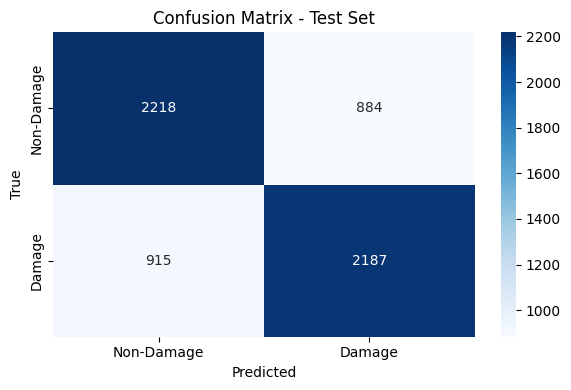

In [4]:
# ====================== Imports ======================
import pandas as pd
import numpy as np
import spacy
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# ====================== Load spaCy model ======================
nlp = spacy.load("en_core_web_sm")

# ====================== Load Data ======================
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# ====================== Preprocess Labels ======================
label_map = {'damage': 1, 'non-damage': 0}
for df in [train_df, test_df]:
    df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
    df['Processed_data'] = df['Processed_data'].fillna("")

# ====================== ELAMO Feature Extraction ======================
def get_spacy_embeddings(texts, fallback_dim=96):
    vectors = []
    for doc in nlp.pipe(texts, disable=["parser", "ner", "tagger"]):
        vec = doc.vector
        if vec is not None and vec.shape[0] > 0:
            vectors.append(vec)
        else:
            vectors.append(np.zeros(fallback_dim))
    return np.vstack(vectors)

def extract_morphological_features(texts):
    pos_tags = []
    lemmas = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        pos_tags.append([token.pos_ for token in doc])
        lemmas.append([token.lemma_ for token in doc])
    return pos_tags, lemmas

def combine_elamo_features(X_embed, pos_tags, lemmas):
    pos_diversity = np.array([[len(set(tags))] for tags in pos_tags])
    lemma_diversity = np.array([[len(set(l))] for l in lemmas])
    return np.hstack((X_embed, pos_diversity, lemma_diversity))

# ====================== Extract Features ======================
print("Extracting embeddings and morphological features...")
X_train_embed = get_spacy_embeddings(train_df['Processed_data'])
X_test_embed = get_spacy_embeddings(test_df['Processed_data'])

train_pos_tags, train_lemmas = extract_morphological_features(train_df['Processed_data'])
test_pos_tags, test_lemmas = extract_morphological_features(test_df['Processed_data'])

X_train = combine_elamo_features(X_train_embed, train_pos_tags, train_lemmas)
X_test = combine_elamo_features(X_test_embed, test_pos_tags, test_lemmas)

y_train = train_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# ====================== Apply SMOTE to Train and Test ======================
print("Before SMOTE - Train:", np.bincount(y_train))
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE - Train:", np.bincount(y_train_smote))

print("Before SMOTE - Test:", np.bincount(y_test))
X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)
print("After SMOTE - Test:", np.bincount(y_test_smote))

# ====================== Random Forest Model ======================
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# ====================== Train the Model ======================
rf_model.fit(X_train_smote, y_train_smote)

# ====================== Evaluate on Test Set ======================
test_preds = rf_model.predict(X_test_smote)
test_proba = rf_model.predict_proba(X_test_smote)[:, 1]
roc_auc = roc_auc_score(y_test_smote, test_proba)

print("\n📊 Test Evaluation Summary:")
print(f"✅ Test Accuracy   : {accuracy_score(y_test_smote, test_preds):.4f}")
print(f"✅ Test ROC-AUC    : {roc_auc:.4f}")
print("✅ Classification Report:\n", classification_report(y_test_smote, test_preds, target_names=['Non-Damage', 'Damage']))

# ====================== Confusion Matrix ======================
cm = confusion_matrix(y_test_smote, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
